#Importações

In [57]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import math

#Modelos

In [58]:
def sigma(z):
  return 1/(1+np.exp(-z))
  
def gd_step_logistic(x, y, w):
  y_pred = np.apply_along_axis(sigma, 0, np.dot(x, w))
  err = y - y_pred
  medias = (err * x).mean(axis = 0).reshape(-1, 1)
  return w + alpha * medias

def gd_logistic(x, y, ts_x, ts_y):
  w = np.full(x.shape[1], 0.001).reshape(-1, 1)
  for i in range(epocas):
    w = gd_step_logistic(x, y, w)
  y_pred = np.apply_along_axis(sigma, 0, np.dot(ts_x, w))
  return (y_pred > 0.5).astype(ts_y.dtype)

In [59]:
def pb_dg(pck, det, mean, inv):
  return lambda x: (np.log(pck) - 0.5 * np.log(det) - 0.5 * (x - mean) @ inv @ (x - mean).T).diagonal()

def discriminant_gauss(x, y, ts_x, ts_y):
  est = []
  for i in range(num_classes):
    classe_index = np.nonzero(y == i)[0]
    classe = x[classe_index]

    mean = classe.mean(axis = 0)
    cov = np.cov(classe, rowvar = False)
    inv_cov = np.linalg.inv(cov)
    det = np.linalg.det(cov)

    pb_f = pb_dg(1/num_classes, det, mean, inv_cov)
    est.append(pb_f)

  pred_prob = np.array([pb_f(ts_x) for pb_f in est]).T
  return np.argmax(pred_prob, axis = 1).reshape(-1, 1)

In [60]:
def pb_nbg(pck, mean, var):
  return lambda x: np.log(pck) - 0.5 * np.sum(np.log(2 * np.pi * var), axis = 1) - 0.5 * np.sum(((x - mean) ** 2)/var, axis = 1)

def naive_bayes_gauss(x, y, ts_x, ts_y):
  est = []
  for i in range(num_classes):
    classe_index = np.nonzero(y == i)[0]
    classe = x[classe_index]

    mean = classe.mean(axis = 0, keepdims = True)
    var = classe.var(axis = 0, ddof=1, keepdims = True)

    pb_f = pb_nbg(1/num_classes, mean, var)
    est.append(pb_f)

  pred_prob = np.array([pb_f(ts_x) for pb_f in est]).T
  return np.argmax(pred_prob, axis = 1).reshape(-1, 1)


#Funções Úteis

In [61]:
def plot_custo(epocas, custos, label):
  fig, ax = plt.subplots(figsize=(7, 5))
  ax.plot(np.arange(epocas), custos, 'r')
  ax.set_xlabel(label)
  ax.set_ylabel('Custo')
  
def plot_graph(fold, acuracias):
  plt.plot(range(1, fold+1), acuracias)
  plt.xlabel('Fold')
  plt.ylabel('Acurácia')
  plt.title('Validação Cruzada ({} folds)'.format(fold))
  plt.show()

def plot_graph_by_class(fold, acu_classes, classes):
  color = ['r', 'b', 'g', 'y', 'p']
  for i in range(len(acu_classes)):
    plt.plot(range(1, fold+1), acu_classes[i], color[i])
  plt.legend([i for i in range(num_classes)], loc=0, frameon=True)
  plt.xlabel("Fold")
  plt.ylabel('Acurácia')
  plt.title('Validação Cruzada por Classe ({} folds)'.format(fold))
  plt.show()

In [62]:
def normalizacao(x, y):
  x_max = np.max(x, axis = 0)
  x_min = np.min(x, axis = 0)

  y_max = np.max(y, axis = 0)
  y_min = np.min(y, axis = 0)

  x = ((x - x_min)/(x_max - x_min))
  y = ((y - y_min)/(y_max - y_min))

  return x, x_max, x_min, y, y_max, y_min

def desnormalizacao(data, max, min):
  return data*(max - min) + min

In [63]:
def separate_data(data):
  x = np.array(data[:, 0:-1])
  y = np.array(data[:, -1]).reshape(-1, 1)

  return x, y

In [64]:
def cross_entropy_loss(y, y_pred):
  return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

In [65]:
def acur(y, y_p):
  return np.sum(y == y_p)/y.shape[0]

def acur_by_class(y, y_p, c):
  return np.sum((y == c) & (y_p == c)) / np.sum(y == c)

def validation(data, fold, num_classes, model):
  part = int(data.shape[0]/fold)
  acuracias = []
  acuracias_by_classes = np.empty((num_classes, fold))

  for i in range(1, fold + 1):
    init, final = (i-1) * part, i * part

    training = np.concatenate((data[0:init], data[final:data.shape[0]]), axis = 0)
    tr_x, tr_y = separate_data(training)
    tr_x, tr_x_max, tr_x_min, _, tr_y_max, tr_y_min = normalizacao(tr_x, tr_y)

    test = np.array(data[init:final])

    ts_x, ts_y = separate_data(test)
    ts_x = (ts_x - tr_x_min) / (tr_x_max - tr_x_min)

    y_pred = model(tr_x, tr_y, ts_x, ts_y)

    acuracia = acur(ts_y, y_pred)
    acuracias.append(acuracia)

    for a in range(num_classes):
      acuracias_by_classes[a][i - 1] = acur_by_class(ts_y, y_pred, a)
  
  return acuracias, acuracias_by_classes

#Questão 1

In [66]:
data = np.genfromtxt('/content/drive/MyDrive/Colab Notebooks/breastcancer.csv', delimiter=',')
data.shape

(569, 31)

In [67]:
alpha = 0.1
epocas = 9000
fold = 10
num_classes = 2

##Regressão Logística

In [68]:
acr, acr_by_c = validation(data, fold, num_classes, gd_logistic)

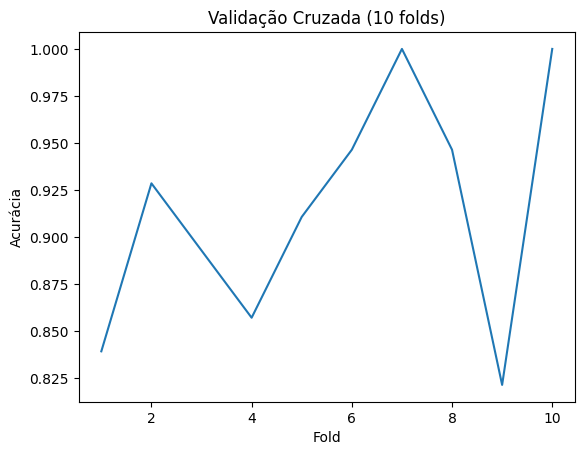

Global
Média: 0.9142857142857143
Desvio padrão: 0.05911766199016732


In [69]:
plot_graph(fold, acr)
print("Global")
print("Média:", np.mean(acr))
print("Desvio padrão:", np.std(acr))

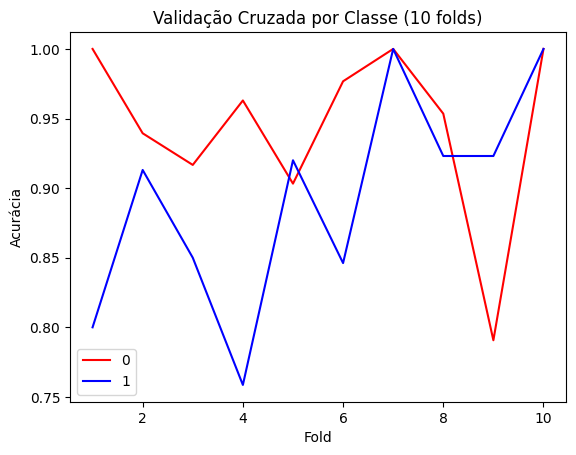

Classe 0
Média: 0.9443179608033322
Desvio padrão: 0.06071347353927106

Classe 1
Média: 0.8933971860223734
Desvio padrão: 0.07522417645671475



In [70]:
plot_graph_by_class(fold, acr_by_c, num_classes)
for i in range(num_classes):
  print("Classe", i)
  print("Média:", np.mean(acr_by_c[i]))
  print("Desvio padrão:", np.std(acr_by_c[i]))
  print()

##Análise do discriminante Gaussiano

In [71]:
acr, acr_by_c = validation(data, fold, num_classes, discriminant_gauss)

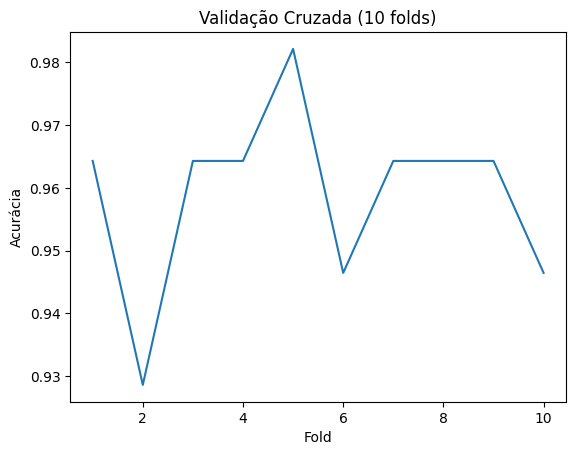

Global
Média: 0.9589285714285714
Desvio padrão: 0.013946874421261878


In [72]:
plot_graph(fold, acr)
print("Global")
print("Média:", np.mean(acr))
print("Desvio padrão:", np.std(acr))

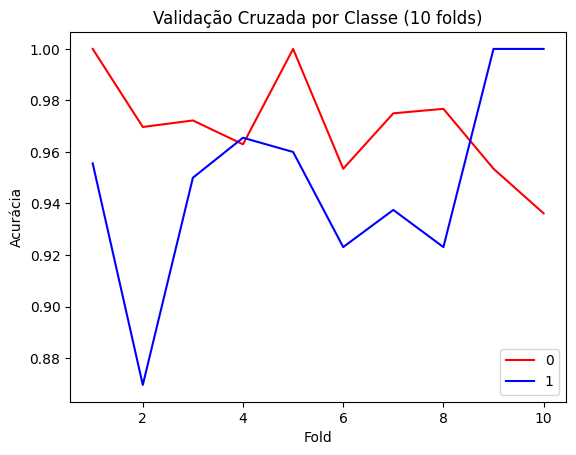

Classe 0
Média: 0.9699773297880672
Desvio padrão: 0.01901249881486515

Classe 1
Média: 0.9484291860480016
Desvio padrão: 0.03663697969013914



In [73]:
plot_graph_by_class(fold, acr_by_c, num_classes)
for i in range(num_classes):
  print("Classe", i)
  print("Média:", np.mean(acr_by_c[i]))
  print("Desvio padrão:", np.std(acr_by_c[i]))
  print()

##Naive Bayes Gaussiano

In [74]:
acr, acr_by_c = validation(data, fold, num_classes, naive_bayes_gauss)

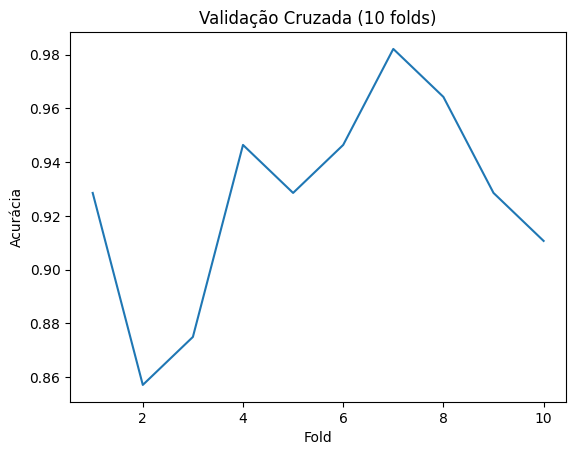

Global
Média: 0.9267857142857142
Desvio padrão: 0.03611383645742265


In [75]:
plot_graph(fold, acr)
print("Global")
print("Média:", np.mean(acr))
print("Desvio padrão:", np.std(acr))

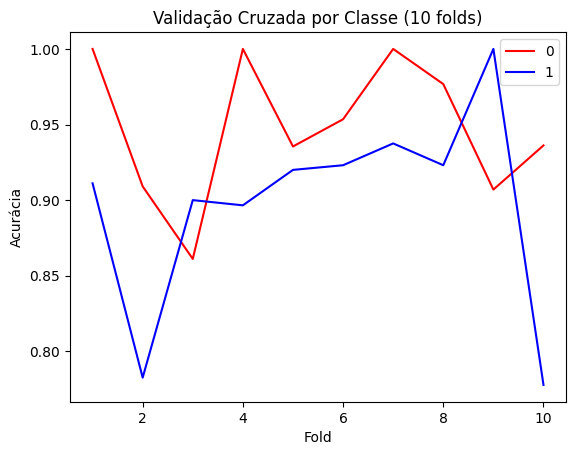

Classe 0
Média: 0.9479065406261302
Desvio padrão: 0.04473406347562426

Classe 1
Média: 0.8971703154832842
Desvio padrão: 0.06453340603960217



In [76]:
plot_graph_by_class(fold, acr_by_c, num_classes)
for i in range(num_classes):
  print("Classe", i)
  print("Média:", np.mean(acr_by_c[i]))
  print("Desvio padrão:", np.std(acr_by_c[i]))
  print()

# Questão 2

In [77]:
data = np.genfromtxt('/content/drive/MyDrive/Colab Notebooks/vehicle.csv', delimiter=',')
data.shape

(846, 19)

In [78]:
alpha = 0.1
epocas = 9000
fold = 10
num_classes = 4

##Regressão Softmax

In [79]:
def hot_encoding(y):
  out = np.empty((y.shape[0], 1, 4))
  for i in range(num_classes):
    out_index = np.nonzero(y == i)[0]
    zero = np.zeros(num_classes)
    zero[i] = 1
    out[out_index] = zero
  return out

In [80]:
def softmax(z):
  return np.exp(z) / np.sum(np.exp(z), axis = 1, keepdims = True)

def gd_step_gd_softmax(x, y, w):
  y_pred = softmax(x @ w)
  err = y_pred - y
  medias = (1/x.shape[0]) * (x.T @ err)
  return w + alpha * medias

def gd_softmax(x, y, ts_x, ts_y):
  w = np.full((x.shape[1], num_classes), 0.1)
  y = hot_encoding(y)
  
  for i in range(epocas):
    w = gd_step_gd_softmax(x, y, w)

  return np.argmax(softmax(ts_x @ w), axis=1)

In [81]:
# acr, acr_by_c = validation(data, fold, num_classes, gd_softmax)

In [82]:
# plot_graph(fold, acr)
# print("Global")
# print("Média:", np.mean(acr))
# print("Desvio padrão:", np.std(acr))

In [83]:
# plot_graph_by_class(fold, acr_by_c, num_classes)
# print(acr_by_c)
# for i in range(num_classes):
#   print("Classe", i)
#   print("Média:", np.mean(acr_by_c[i]))
#   print("Desvio padrão:", np.std(acr_by_c[i]))
#   print()

##Análise do discriminante Gaussiano

In [84]:
acr, acr_by_c = validation(data, fold, num_classes, discriminant_gauss)

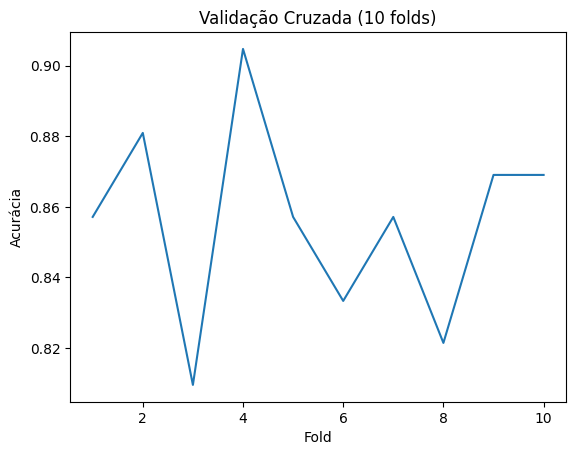

Global
Média: 0.8559523809523808
Desvio padrão: 0.026858367077805898


In [85]:
plot_graph(fold, acr)
print("Global")
print("Média:", np.mean(acr))
print("Desvio padrão:", np.std(acr))

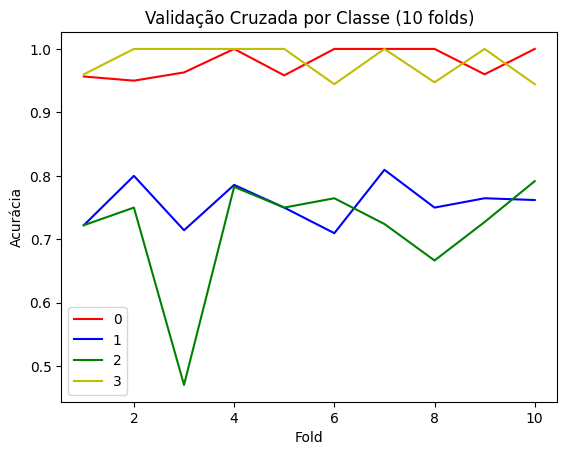

Classe 0
Média: 0.9787818035426732
Desvio padrão: 0.021438502239705875

Classe 1
Média: 0.7568034095358573
Desvio padrão: 0.0329950636841465

Classe 2
Média: 0.7149869027161999
Desvio padrão: 0.0881639895198406

Classe 3
Média: 0.9796257309941521
Desvio padrão: 0.025282037563138297



In [86]:
plot_graph_by_class(fold, acr_by_c, num_classes)
for i in range(num_classes):
  print("Classe", i)
  print("Média:", np.mean(acr_by_c[i]))
  print("Desvio padrão:", np.std(acr_by_c[i]))
  print()

##Naive Bayes Gaussiano

In [87]:
acr, acr_by_c = validation(data, fold, num_classes, naive_bayes_gauss)

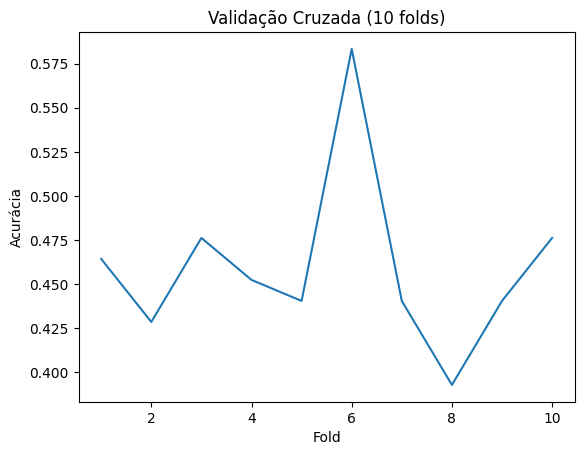

Global
Média: 0.4595238095238095
Desvio padrão: 0.047380354147934296


In [88]:
plot_graph(fold, acr)
print("Global")
print("Média:", np.mean(acr))
print("Desvio padrão:", np.std(acr))

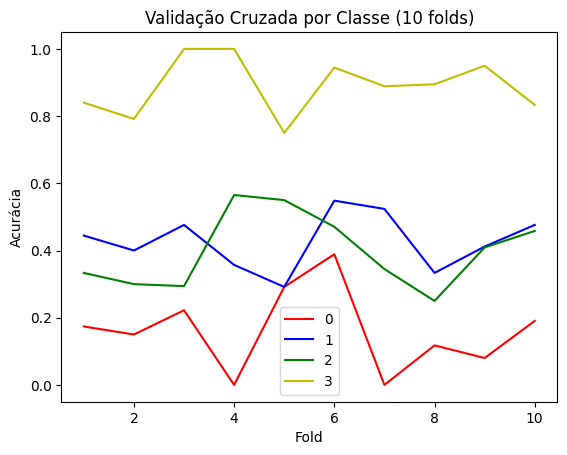

Classe 0
Média: 0.16148140705557587
Desvio padrão: 0.11584128643475794

Classe 1
Média: 0.42629295804343237
Desvio padrão: 0.0788513264114483

Classe 2
Média: 0.3975508435621761
Desvio padrão: 0.10459657567875778

Classe 3
Média: 0.8893070175438597
Desvio padrão: 0.08109477361742



In [89]:
plot_graph_by_class(fold, acr_by_c, num_classes)
for i in range(num_classes):
  print("Classe", i)
  print("Média:", np.mean(acr_by_c[i]))
  print("Desvio padrão:", np.std(acr_by_c[i]))
  print()